In [1]:
# %pip install numpy
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install pylatexenc
# %pip install opencv-python
# %pip install qiskit==1.2.4
# %pip install qiskit_machine_learning
# %pip install joblib
# %pip install pandas
# %pip install seaborn

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import kagglehub
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.algorithms import QSVC
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from joblib import Parallel, delayed
from tqdm import tqdm
from utils.qtkcallback import QKTCallback

#### Download dataset  https://www.kaggle.com/datasets/gurjeetkaurmangat/kidney-ultrasound-images-stone-and-no-stone

In [3]:
path = kagglehub.dataset_download("gurjeetkaurmangat/kidney-ultrasound-images-stone-and-no-stone")

# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [4]:
# !rm -rf f'{path}/my dataset final 512x512(implemented)/Normal/.DS_Store'
# !rm -rf f'{path}/my dataset final 512x512(implemented)/stone/.DS_Store'

In [5]:
dataset_path_normal = f'{path}/my dataset final 512x512(implemented)/Normal'
dataset_path_stone = f'{path}/my dataset final 512x512(implemented)/stone'

#### Count files in directory

In [6]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])

print("Length dataset_path_normal:", count_images(dataset_path_normal))
print("Length dataset_path_stone:", count_images(dataset_path_stone))

Length dataset_path_normal: 4414
Length dataset_path_stone: 5002


#### Check data

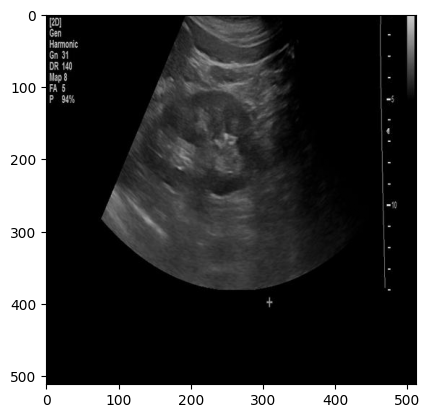

In [7]:
kid_image = cv2.imread(f'{dataset_path_stone}/Stone_4.JPG', cv2.IMREAD_GRAYSCALE)
plt.imshow(kid_image, cmap='gray')

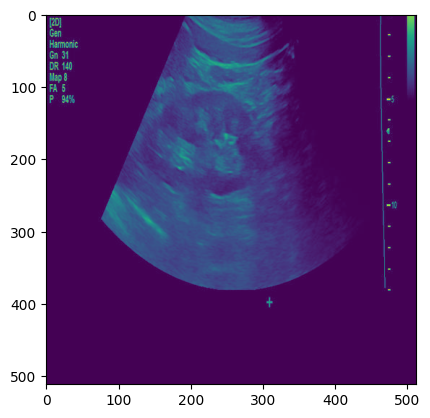

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
kid_image_scaled = transform_img(kid_image)
colored_kid = cm.viridis(kid_image_scaled)
plt.imshow(colored_kid)

#### Load and preprocess images

In [9]:
img_size = (224, 224)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and stores them as numpy arrays (3D).

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)


def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A numpy array of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

#### Display images for train

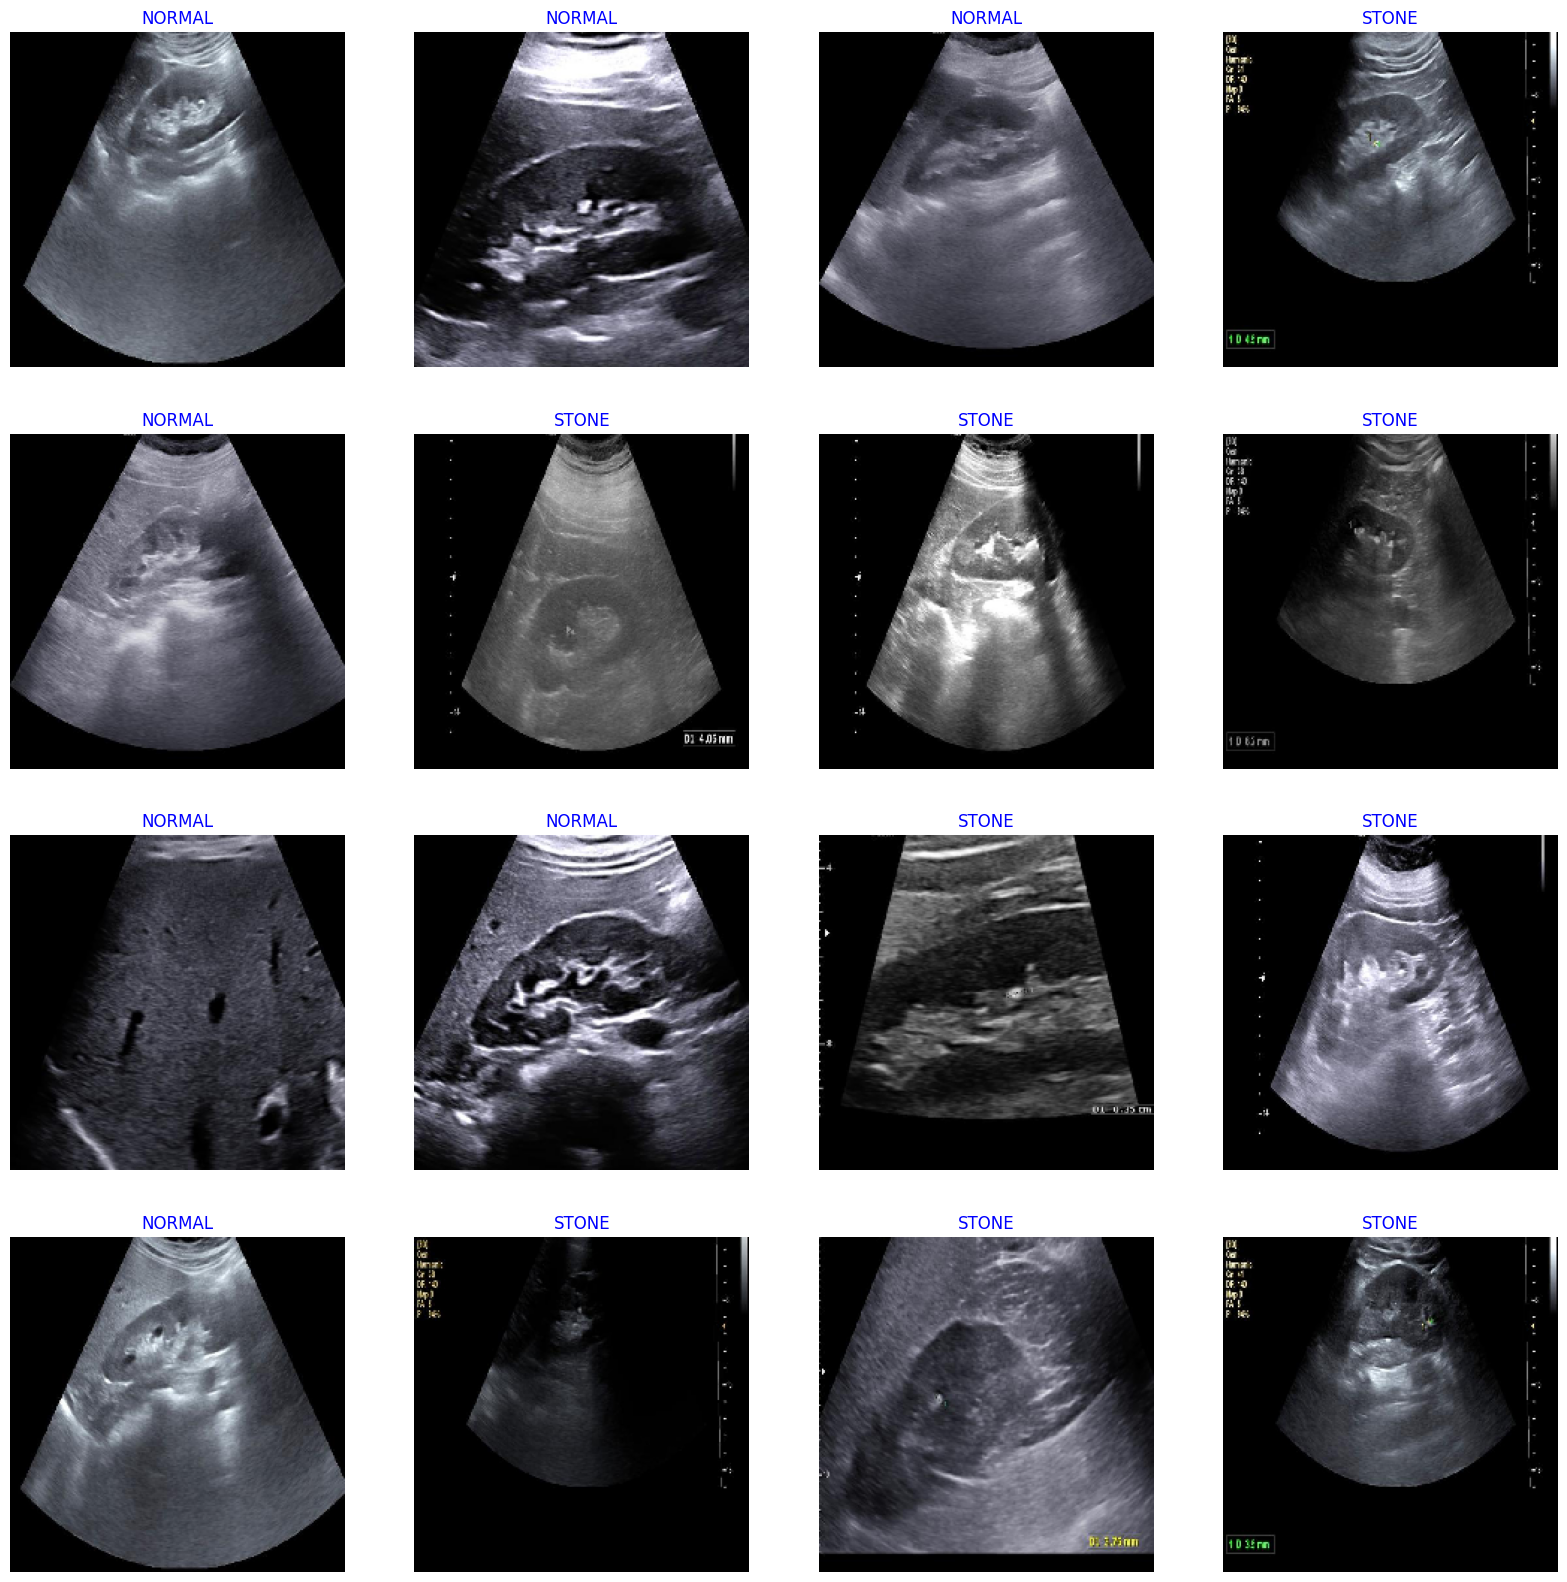

In [10]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_normal, 'NORMAL')
stone_filepaths, stone_labels = load_file_paths_and_labels(dataset_path_stone, 'STONE')

all_filepaths = stone_filepaths + normal_filepaths
all_labels = stone_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'NORMAL': 0, 'STONE': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

#### Get training and testing data

In [11]:
normal_data, normal_labels = load_and_limit_data(dataset_path_normal, label=0, num_samples=150)
stone_data, stone_labels = load_and_limit_data(dataset_path_stone, label=1, num_samples=200)

all_data = np.concatenate([normal_data, stone_data], axis=0)
all_labels = np.concatenate([normal_labels, stone_labels], axis=0)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

#### Reduce to n Dimensions

In [12]:
def reduce_to_n_dimensions(data, n_dimensions):
    """
    Reduces the number of features in the dataset to n dimensions by averaging subsets of features.
    
    Args:
        data (np.ndarray): Input dataset of shape (n_samples, n_features).
        n_dimensions (int): Target number of dimensions.
    
    Returns:
        np.ndarray: Reduced dataset of shape (n_samples, n_dimensions).
    """
    n_features = data.shape[1]
    if n_dimensions > n_features:
        raise ValueError("Target dimensions cannot be greater than the number of features in the dataset.")
    
    # Split features into n_dimensions equal parts
    split_size = n_features // n_dimensions
    reduced_data = np.zeros((data.shape[0], n_dimensions))
    
    for i in range(n_dimensions):
        start_idx = i * split_size
        end_idx = start_idx + split_size if i < n_dimensions - 1 else n_features
        reduced_data[:, i] = np.mean(data[:, start_idx:end_idx], axis=1)
    
    return reduced_data

In [13]:
X_train_red_2d = X_train.reshape(X_train.shape[0], -1)
X_test_red_2d = X_test.reshape(X_test.shape[0], -1)

In [14]:
n_dimensions = 8
X_train_reduced = reduce_to_n_dimensions(X_train_red_2d, n_dimensions)
X_test_reduced = reduce_to_n_dimensions(X_test_red_2d, n_dimensions)

#### Class Weights

In [15]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

#### Display the categorized file paths and labels

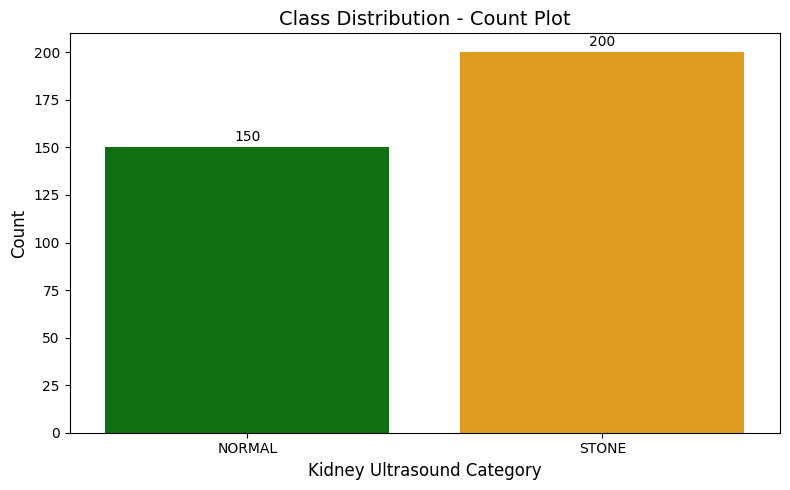

In [16]:
df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'STONE' for lbl in all_labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'STONE': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('Kidney Ultrasound Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Plot the data

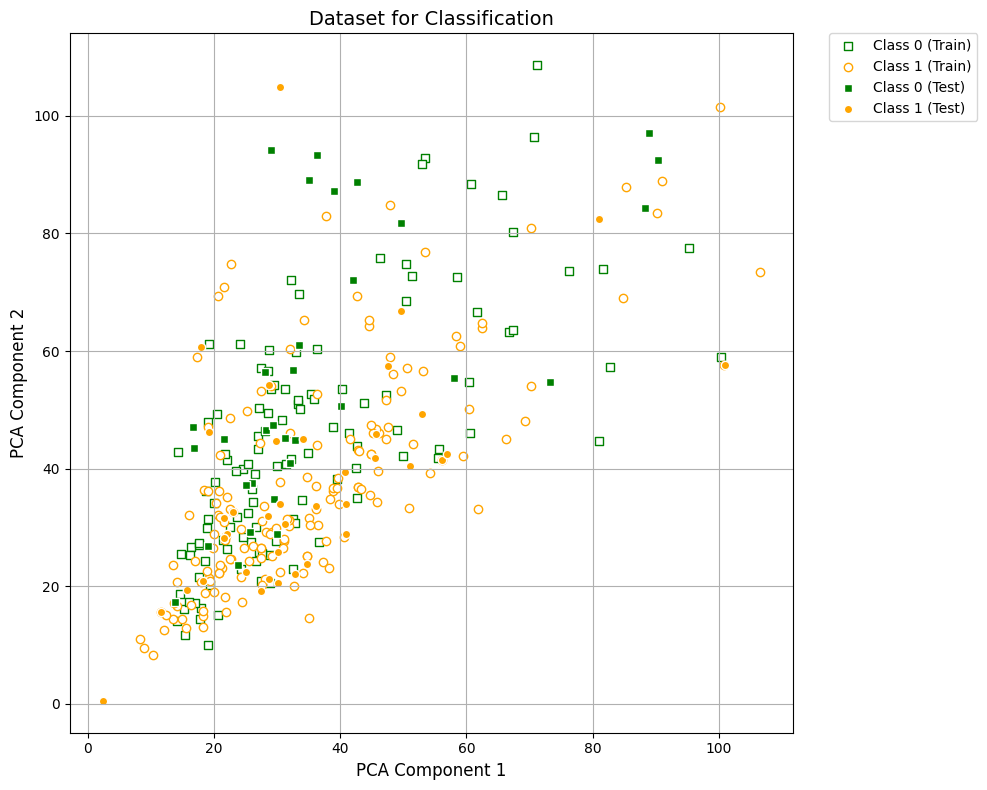

In [17]:
plt.figure(figsize=(10, 8))

plt.scatter(
    X_train_reduced[np.where(y_train == 0)[0], 0],
    X_train_reduced[np.where(y_train == 0)[0], 1],
    marker="s",
    facecolors="w",
    edgecolors="green",
    label="Class 0 (Train)",
)

plt.scatter(
    X_train_reduced[np.where(y_train == 1)[0], 0],
    X_train_reduced[np.where(y_train == 1)[0], 1],
    marker="o",
    facecolors="w",
    edgecolors="orange",
    label="Class 1 (Train)",
)

plt.scatter(
    X_test_reduced[np.where(y_test == 0)[0], 0],
    X_test_reduced[np.where(y_test == 0)[0], 1],
    marker="s",
    facecolors="green",
    edgecolors="w",
    label="Class 0 (Test)",
)

plt.scatter(
    X_test_reduced[np.where(y_test == 1)[0], 0],
    X_test_reduced[np.where(y_test == 1)[0], 1],
    marker="o",
    facecolors="orange",
    edgecolors="w",
    label="Class 1 (Test)",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset for Classification", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Quantum Circuit

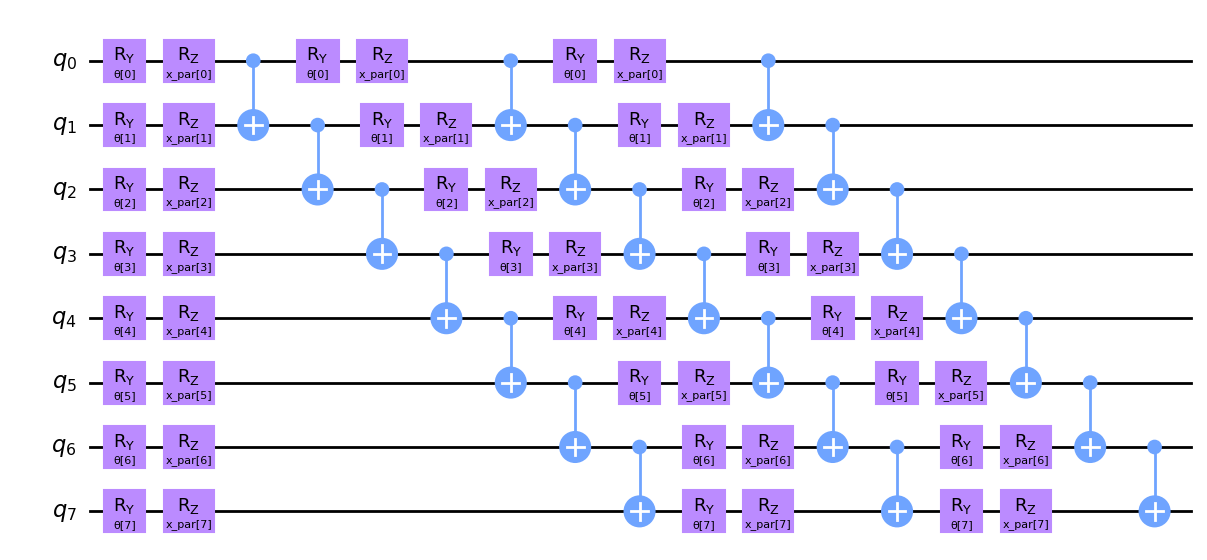

In [18]:
num_qubits = 8
qc = QuantumCircuit(num_qubits)
input_params = ParameterVector("x_par", num_qubits)
training_params = ParameterVector("θ", num_qubits)

for _ in range(3):
    for i, param in enumerate(training_params):
        qc.ry(param, qc.qubits[i])
    for i, param in enumerate(input_params):
        qc.rz(param, qc.qubits[i])
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)

qc.draw("mpl", style="clifford")

#### Initialize the optimizer, Set Up the Quantum Kernel and Quantum Kernel Trainer

In [19]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

quant_kernel = TrainableFidelityQuantumKernel(
    fidelity=fidelity,
    feature_map=qc,
    training_parameters=training_params,
)

cb_qkt = QKTCallback()

spsa_opt = SPSA(
    maxiter=10,
    callback=cb_qkt.callback,
    learning_rate=0.02,
    perturbation=0.01
)

#### Distribute the training process for different initializations across multiple CPU cores.

In [20]:
def train_qkt_with_initial_point(initial_point, X_train, y_train, quant_kernel, loss_function, optimizer):
    """Train QuantumKernelTrainer with a specific initial point."""
    qkt = QuantumKernelTrainer(
        quantum_kernel=quant_kernel,
        loss=loss_function,
        optimizer=optimizer,
        initial_point=initial_point
    )
    results = qkt.fit(X_train, y_train)
    return results

# Parallelize training over different initial points
num_initializations = 4
initial_points = [np.random.randn(num_qubits) * 0.1 for _ in range(num_initializations)]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_qkt_with_initial_point)(
        initial_point,
        X_train_reduced[:50],
        y_train[:50],
        quant_kernel,
        SVCLoss(),
        spsa_opt
    )
    for initial_point in initial_points
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  5.4min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  5.5min finished


In [21]:
optimized_kernels = [result.quantum_kernel for result in results]

#### Save the optimized kernel to a file

In [22]:
with open('kernels/optimized_QuantumKernel.pkl', 'wb') as f:
    pickle.dump(optimized_kernels, f)

#### Load the optimized kernel from the file

In [23]:
with open('kernels/optimized_QuantumKernel.pkl', 'rb') as f:
    loaded_kernel = pickle.load(f)

#### Fit the QSVC

In [24]:
for idx, kernel in enumerate(tqdm(optimized_kernels, desc="Training QSVC for each kernel")):
    print(f"Training QSVC with kernel {idx + 1}/{len(optimized_kernels)}...")
    qsvc = QSVC(quantum_kernel=kernel, class_weight=class_weights_dict, probability=True)
    qsvc.fit(X_train_reduced, y_train)
    print(f"Finished training QSVC with kernel {idx + 1}/{len(optimized_kernels)}.\n")

Training QSVC for each kernel:   0%|          | 0/4 [00:00<?, ?it/s]

Training QSVC with kernel 1/4...


Training QSVC for each kernel:  25%|██▌       | 1/4 [05:56<17:49, 356.47s/it]

Finished training QSVC with kernel 1/4.

Training QSVC with kernel 2/4...


Training QSVC for each kernel:  50%|█████     | 2/4 [11:52<11:52, 356.06s/it]

Finished training QSVC with kernel 2/4.

Training QSVC with kernel 3/4...


Training QSVC for each kernel:  75%|███████▌  | 3/4 [17:50<05:56, 356.89s/it]

Finished training QSVC with kernel 3/4.

Training QSVC with kernel 4/4...


Training QSVC for each kernel: 100%|██████████| 4/4 [23:46<00:00, 356.74s/it]

Finished training QSVC with kernel 4/4.



#### Predictions

In [25]:
y_pred = qsvc.predict(X_test_reduced)

In [26]:
qsvc_score = qsvc.score(X_test_reduced, y_test)

print(f"QSVC classification test score: {qsvc_score:.4f}")

QSVC classification test score: 0.6286


#### Save model

In [27]:
qsvc.save('models/QSVC_quantm_trainer_brain_tumor.model')

#### Compute evaluation metrics

In [28]:
classification_rep = metrics.classification_report(y_test, y_pred, output_dict=True, zero_division=True)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, qsvc.decision_function(X_test_reduced))

print("Classification Report:", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report: {'0': {'precision': 0.6521739130434783, 'recall': 0.46875, 'f1-score': 0.5454545454545454, 'support': 32.0}, '1': {'precision': 0.6382978723404256, 'recall': 0.7894736842105263, 'f1-score': 0.7058823529411765, 'support': 38.0}, 'accuracy': 0.6428571428571429, 'macro avg': {'precision': 0.6452358926919519, 'recall': 0.6291118421052632, 'f1-score': 0.625668449197861, 'support': 70.0}, 'weighted avg': {'precision': 0.6446412052332496, 'recall': 0.6428571428571429, 'f1-score': 0.6325439266615738, 'support': 70.0}}
Confusion Matrix:
 [[15 17]
 [ 8 30]]
ROC AUC Score: 0.6513157894736843


#### Predicted probability for Positive Class

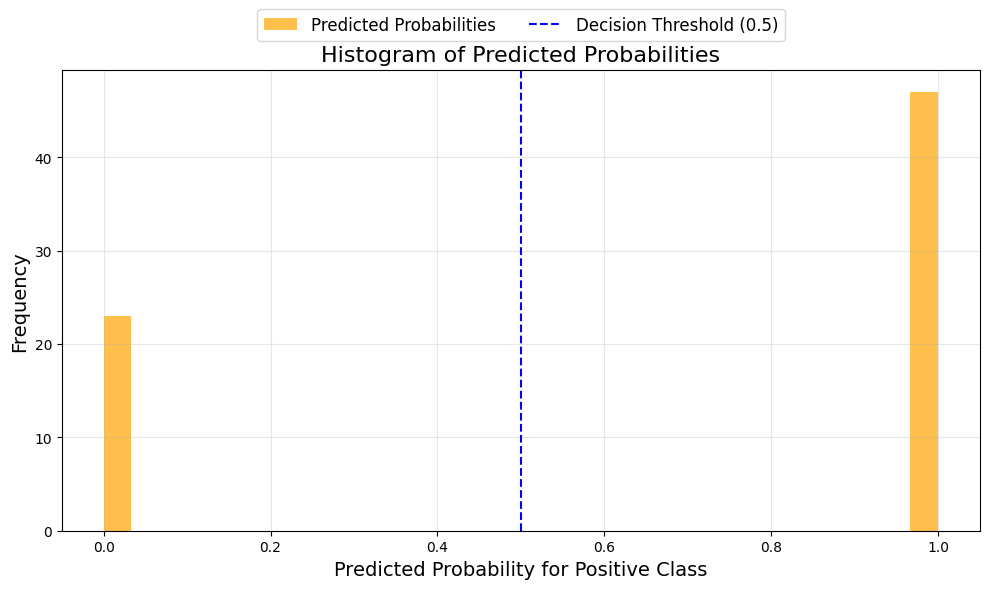

In [29]:
y_pred_probabilities_tensor = torch.tensor(y_pred, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

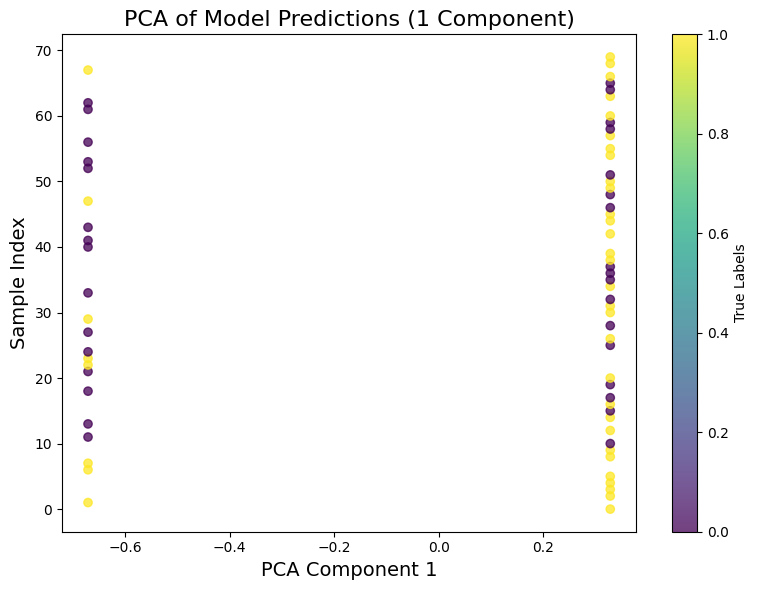

In [30]:
if y_pred.ndim == 1:
    labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))

plt.scatter(features_pca, range(len(features_pca)), c=y_test, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

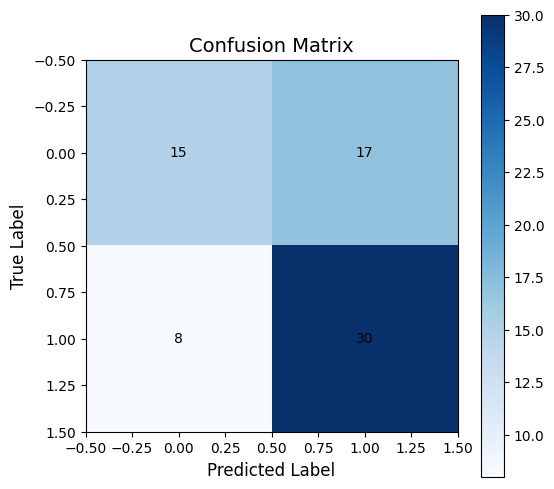

In [31]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()

#### Plot the ROC curve

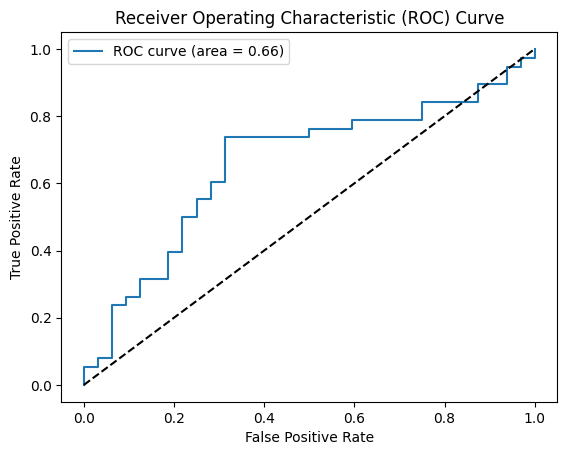

In [33]:
decision_function = qsvc.decision_function(X_test_reduced)

fpr, tpr, _ = metrics.roc_curve(y_test, decision_function)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")

plt.show()

#### Load model

In [34]:
loaded_model = QSVC.load('models/QSVC_quantm_trainer_brain_tumor.model')

#### Test loaded model

In [35]:
train_score = loaded_model.score(X_train_reduced[:10], y_train[:10])
test_score = loaded_model.score(X_test_reduced[:10], y_test[:10])

print(f"Quantum QSVC on the training dataset: {train_score:.2f}")
print(f"Quantum QSVC on the test dataset: {test_score:.2f}")

Quantum QSVC on the training dataset: 1.00
Quantum QSVC on the test dataset: 0.70


In [36]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright